In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [7]:
#read data
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)

C:\Users\advan\AppData\Local\Temp\ipykernel_13684\365243236.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)


In [9]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [11]:
start_date = datetime(2000,1,1)
end_date = datetime(2004,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

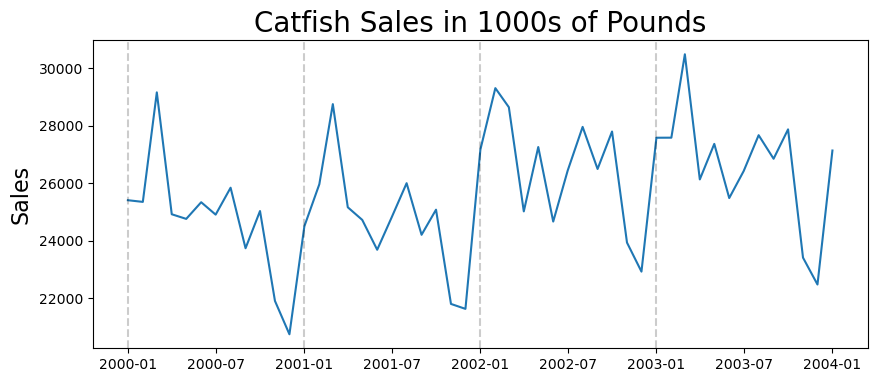

In [19]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
#plt.axhline(lim_catfish_sales.mean(), color='r', alpha=0.2, linestyle='--')

In [21]:
first_diff = lim_catfish_sales.diff()[1:]

We'll do first differencing to make the data stationary

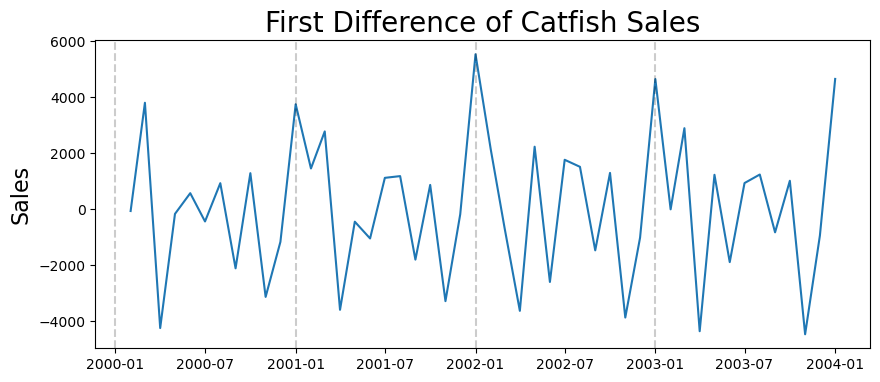

In [23]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
#plt.axhline(first_diff.mean(), color='r', alpha=0.2, linestyle='--')

<BarContainer object of 17 artists>

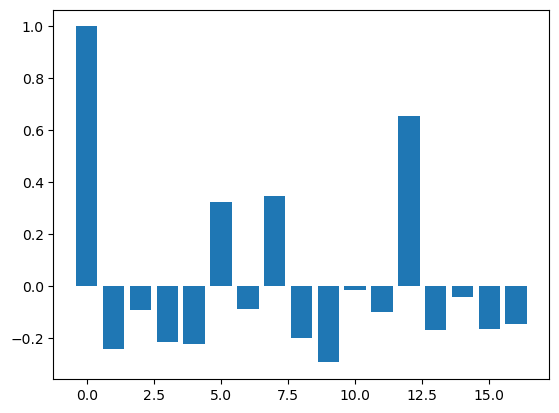

In [28]:
# ACF
acf_vals = acf(first_diff)
plt.bar(range(17), acf_vals[:17])

Based on ACF, we should start with a MA(1) process

<BarContainer object of 15 artists>

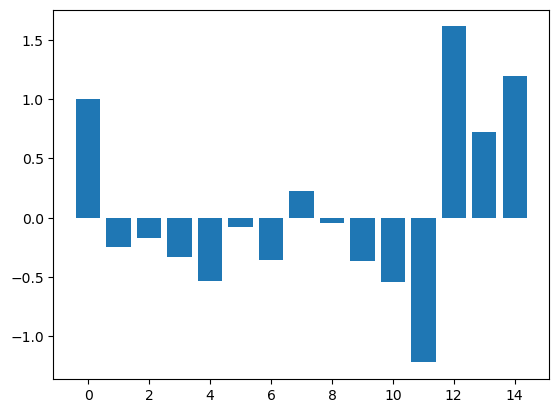

In [31]:
# PACF
pacf_vals = pacf(first_diff)
plt.bar(range(15), pacf_vals[:15])

Based on PACF, we should start with a AR(4) process

In [34]:
# train test split
train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

In [62]:
# define model
model = ARIMA(train_data, order=(4,1,1))

In [64]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.2359910011291504


C:\Users\advan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [66]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   42
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -370.889
Date:                Wed, 11 Sep 2024   AIC                            753.777
Time:                        11:54:34   BIC                            764.059
Sample:                    02-01-2000   HQIC                           757.521
                         - 07-01-2003                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5036      0.137     -3.679      0.000      -0.772      -0.235
ar.L2         -0.3094      0.157     -1.973      0.048      -0.617      -0.002
ar.L3         -0.4706      0.217     -2.168      0.0

The p-values of all the AR and MA lags is below 0.05, which means our model is good

In [69]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [71]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data.values.flatten() - predictions.values

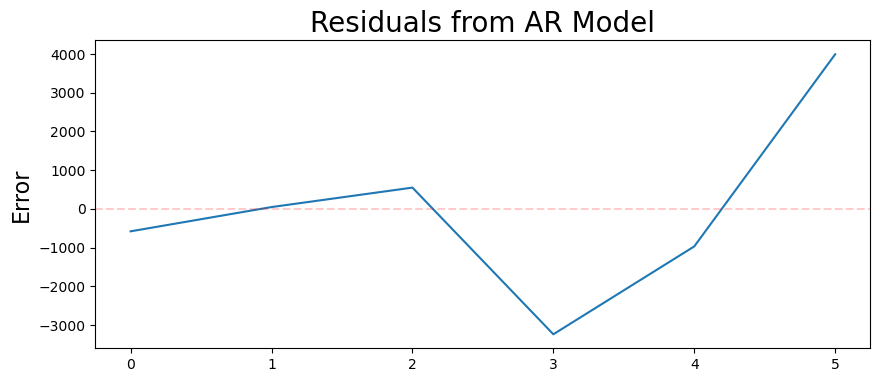

In [73]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

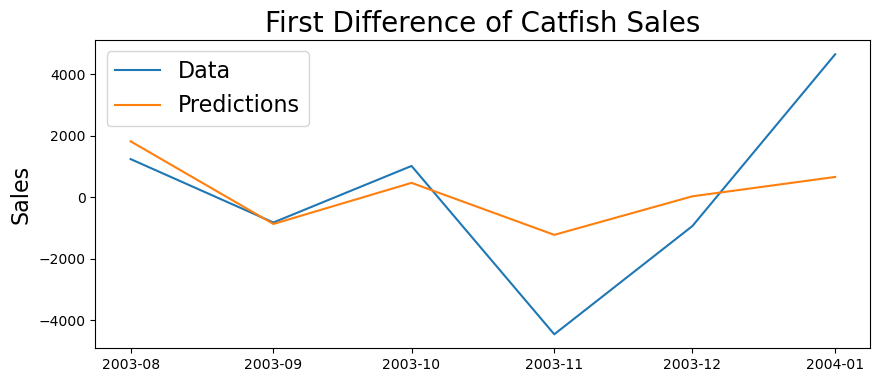

In [75]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [77]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 2160.7491636155605
